In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
# Downloading the relevant image dataset for notMNIST
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [6]:
# Extracts the downloaded files
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [9]:
# Problem 1
# The below code iterates through each of the folders and prints the first 10 images in each train folder
for pic in train_folders:
    print(pic)
    for i in range(0,10):
        img = Image(filename=pic + '/' + os.listdir(pic)[i])
        display(img)
    print()
# The below code iterates through each of the folders and prints the first image in each test folder
for pic in test_folders:
    print(pic)
    img = Image(filename=pic + '/' + os.listdir(pic)[0])
    display(img)
    print()

./notMNIST_large/A



./notMNIST_large/B



./notMNIST_large/C



./notMNIST_large/D



./notMNIST_large/E



./notMNIST_large/F



./notMNIST_large/G



./notMNIST_large/H



./notMNIST_large/I



./notMNIST_large/J



./notMNIST_small/A



./notMNIST_small/B



./notMNIST_small/C



./notMNIST_small/D



./notMNIST_small/E



./notMNIST_small/F



./notMNIST_small/G



./notMNIST_small/H



./notMNIST_small/I



./notMNIST_small/J


In [7]:
# Converts the above image files into a 3D array of the form [image index, x, y]
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not load bitmap "/home/nishanth/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png": No known reason. - it's ok, skipping.
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not load bitmap "/home/nishanth/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png": No known reason. - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not load bitmap "/home/nishanth/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png": No known reason. - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825029
Standard deviation: 0.44312078
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not load bitmap "/home/nishanth/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png": No known reason. -

./notMNIST_large/A.pickle


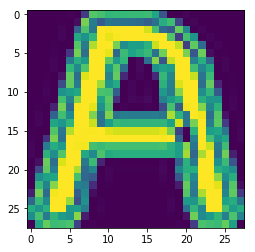

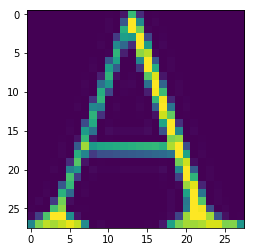

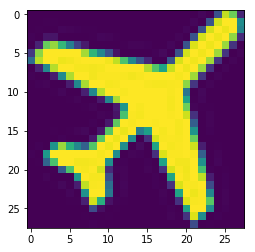

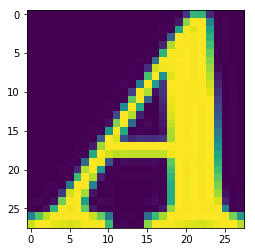

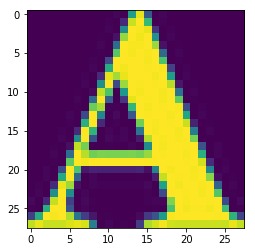


./notMNIST_large/B.pickle


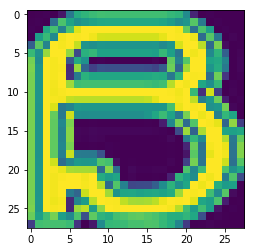

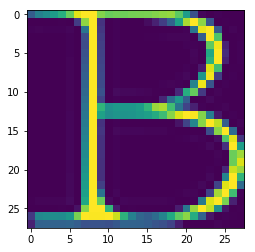

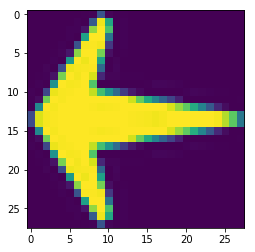

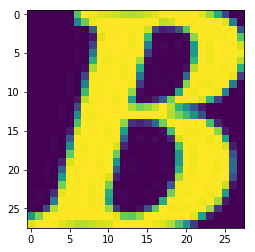

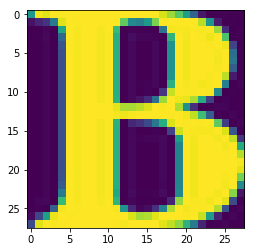


./notMNIST_large/C.pickle


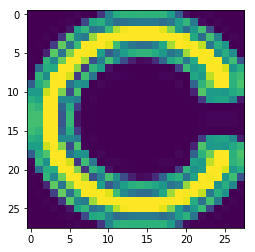

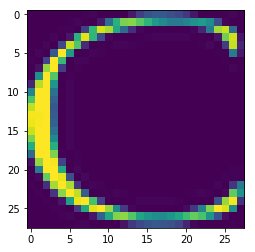

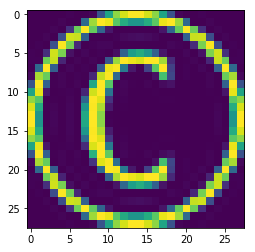

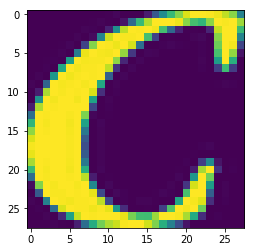

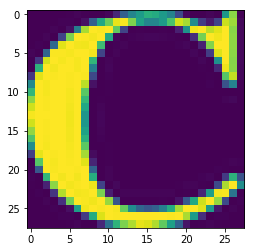


./notMNIST_large/D.pickle


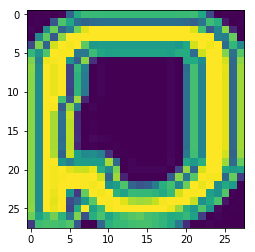

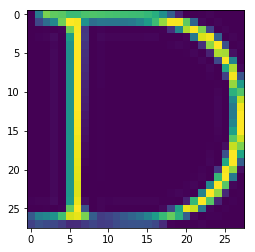

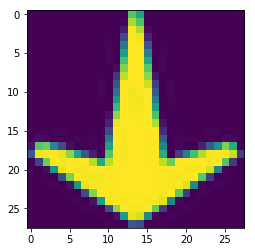

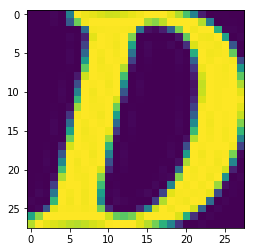

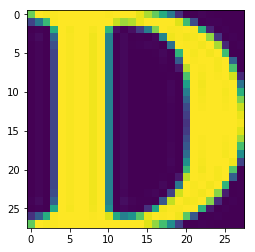


./notMNIST_large/E.pickle


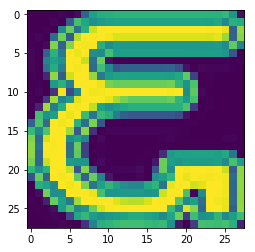

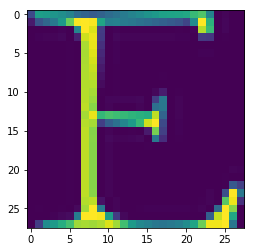

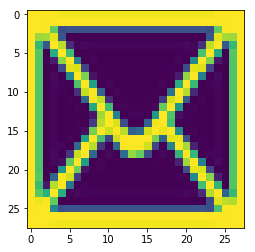

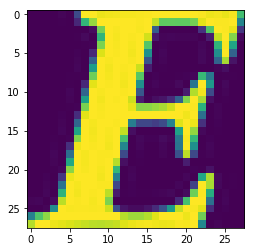

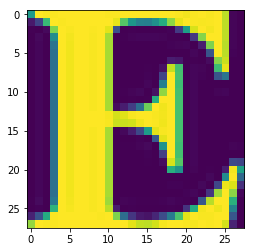


./notMNIST_large/F.pickle


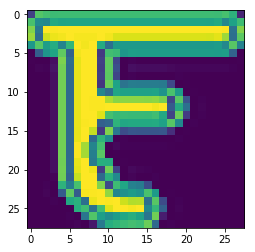

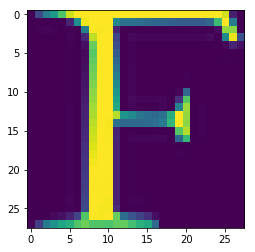

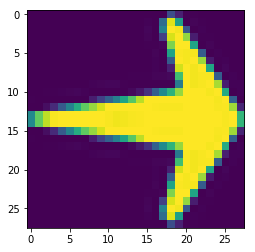

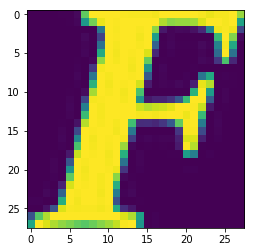

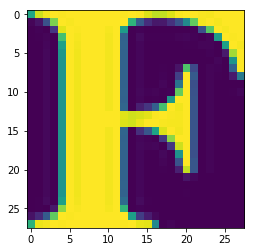


./notMNIST_large/G.pickle


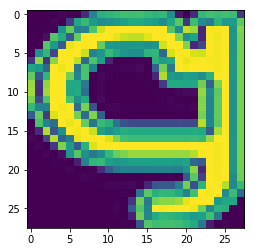

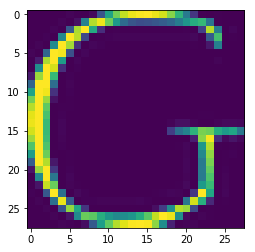

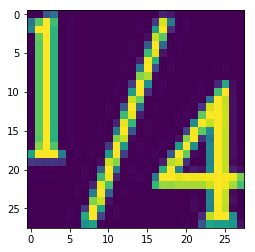

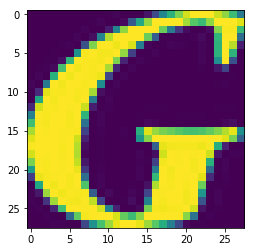

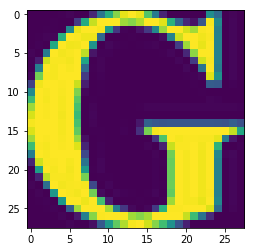


./notMNIST_large/H.pickle


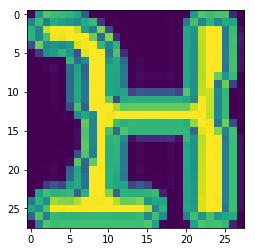

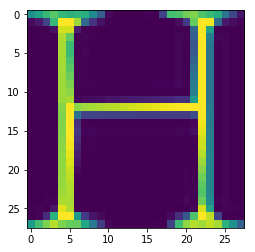

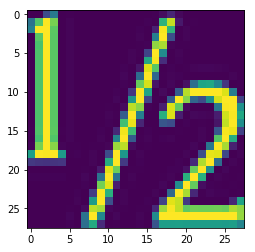

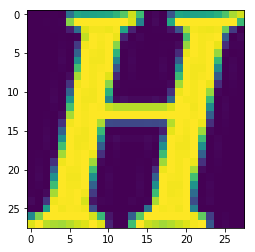

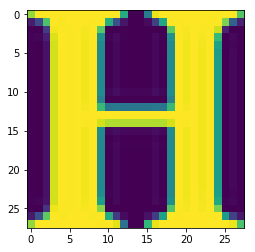


./notMNIST_large/I.pickle


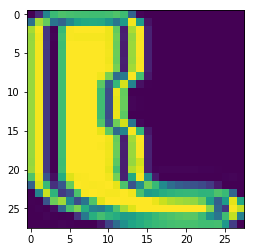

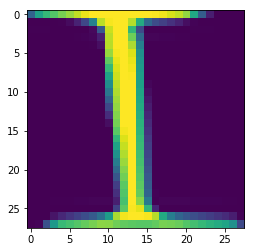

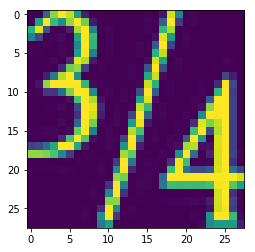

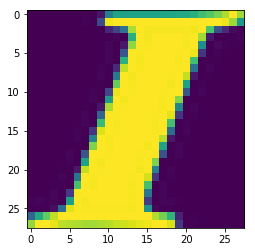

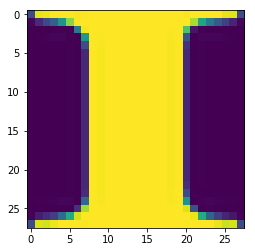


./notMNIST_large/J.pickle


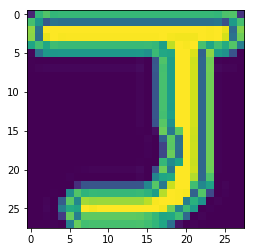

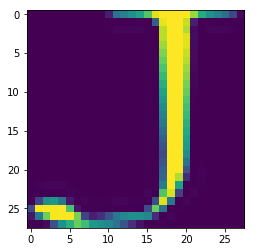

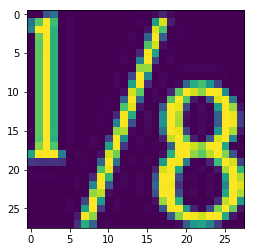

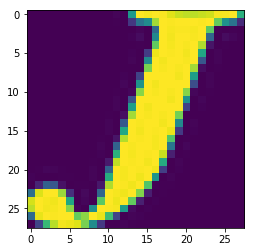

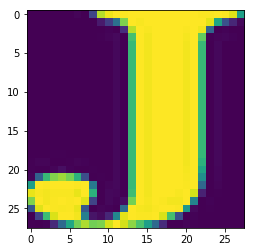


./notMNIST_small/A.pickle


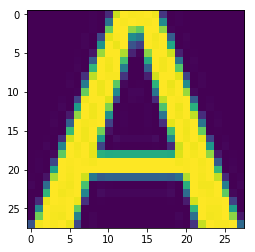


./notMNIST_small/B.pickle


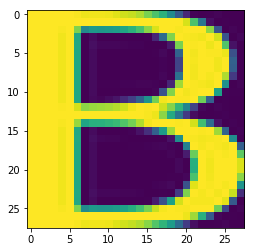


./notMNIST_small/C.pickle


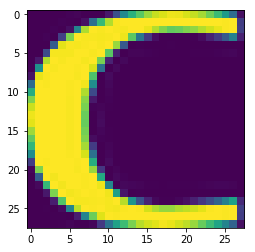


./notMNIST_small/D.pickle


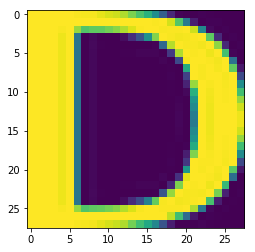


./notMNIST_small/E.pickle


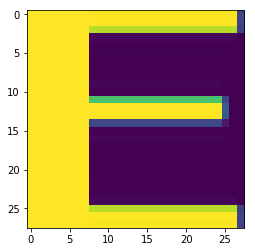


./notMNIST_small/F.pickle


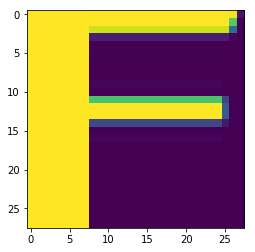


./notMNIST_small/G.pickle


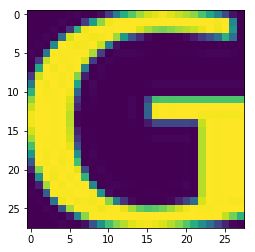


./notMNIST_small/H.pickle


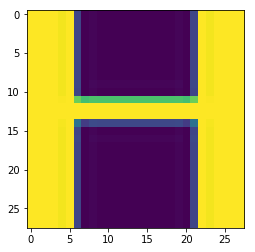


./notMNIST_small/I.pickle


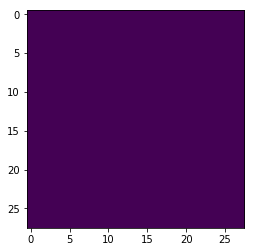


./notMNIST_small/J.pickle


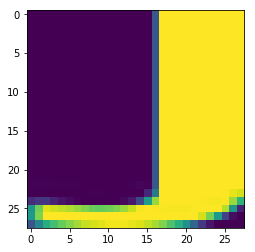

In [38]:
# Problem 2

def display_sample_images(dataset, num_to_sample):
    for array_loc in dataset:
        try:
            with open(array_loc, 'rb') as f:
                curr_array = pickle.load(f)
                print(array_loc)
                for i in range(0, num_to_sample):
                    plt.imshow(curr_array[i,:,:])
                    plt.show()
                print()
        except Exception as e:
            print('Unable to read data from', array_loc, ':', e)
        
# The below code iterates through each of the pickled folders and prints the first 5 images in each pickled folder
display_sample_images(train_datasets, 5)

# The below code iterates through each of the test pickled folders and prints the first image
display_sample_images(test_datasets, 1)

In [34]:
# Problem 3

# The below code iterates through the training dataset and finds the maximum and minimum sizes of the arrays
# If the difference between these sizes is greater than 3 (arbitrarily chosen number), then the dataset is 
# considered too unbalanced. Else, it is balanced. The same is done for the test_dataset

def is_balanced(dataset):
    max_size = 0
    min_size = 0
    for array_loc in dataset:
        try:
            with open(array_loc, 'rb') as f:
                curr_array = pickle.load(f)
                if(max_size == 0 or len(curr_array) > max_size):
                    max_size = len(curr_array)                
                if(min_size == 0 or len(curr_array) < min_size):
                    min_size = len(curr_array)
                print(array_loc + ' size is: ' + str(len(curr_array)))
        except Exception as e:
            print('Unable to read data from', array_loc, ':', e)
    print('Max size is: ' + str(max_size))
    print('Min size is: ' + str(min_size))

    if(max_size - min_size > 5):
        print('Dataset is not balanced')
    else:
        print('Dataset is balanced')
    
is_balanced(train_datasets)
print()
is_balanced(test_datasets)

./notMNIST_large/A.pickle size is: 52909
./notMNIST_large/B.pickle size is: 52911
./notMNIST_large/C.pickle size is: 52912
./notMNIST_large/D.pickle size is: 52911
./notMNIST_large/E.pickle size is: 52912
./notMNIST_large/F.pickle size is: 52912
./notMNIST_large/G.pickle size is: 52912
./notMNIST_large/H.pickle size is: 52912
./notMNIST_large/I.pickle size is: 52912
./notMNIST_large/J.pickle size is: 52911
Max size is: 52912
Min size is: 52909
Dataset is balanced

./notMNIST_small/A.pickle size is: 1872
./notMNIST_small/B.pickle size is: 1873
./notMNIST_small/C.pickle size is: 1873
./notMNIST_small/D.pickle size is: 1873
./notMNIST_small/E.pickle size is: 1873
./notMNIST_small/F.pickle size is: 1872
./notMNIST_small/G.pickle size is: 1872
./notMNIST_small/H.pickle size is: 1872
./notMNIST_small/I.pickle size is: 1872
./notMNIST_small/J.pickle size is: 1872
Max size is: 1873
Min size is: 1872
Dataset is balanced


In [35]:
# This code merges the datasets. It also splits the data randomly into a validation
# and a training set. The code may also prune the dataset depending on the value of the 
# train_size, valid_size and test_size parameters. These can be set to use a smaller 
# number than the total 60000 images in the dataset to try to reduce load on the host 
# computer's memory.
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [36]:
# This code shuffles the data in the three (training, test and validation) datasets

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)


Training Set


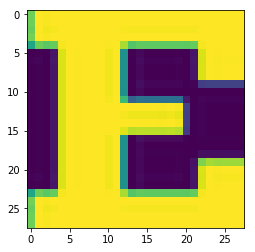

Corresponding label: E


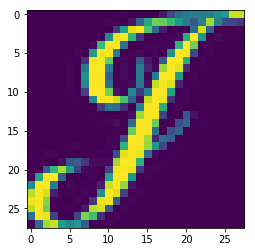

Corresponding label: J


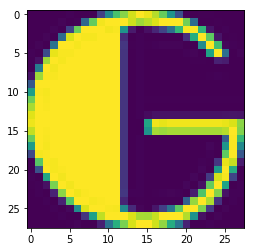

Corresponding label: G


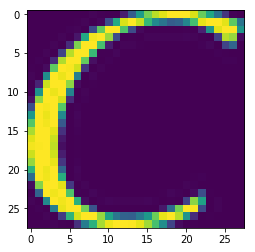

Corresponding label: C


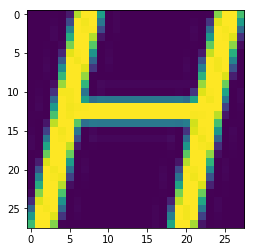

Corresponding label: H


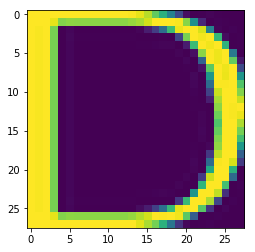

Corresponding label: D


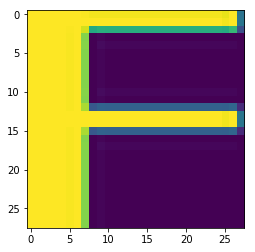

Corresponding label: F


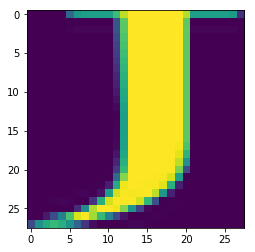

Corresponding label: J


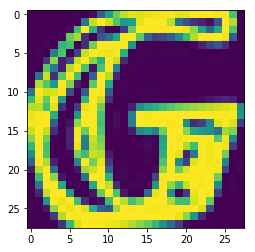

Corresponding label: G


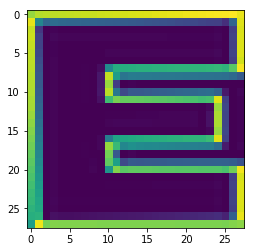

Corresponding label: E

Testing Set


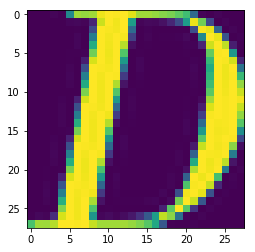

Corresponding label: D


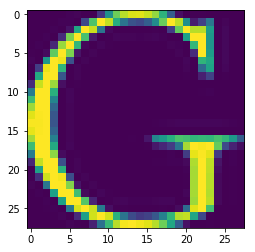

Corresponding label: G


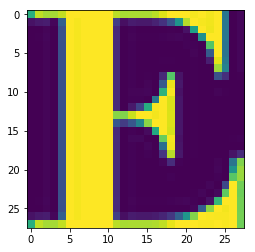

Corresponding label: E


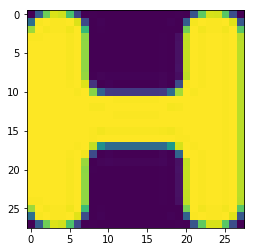

Corresponding label: H


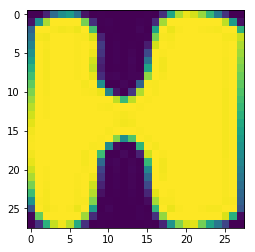

Corresponding label: H


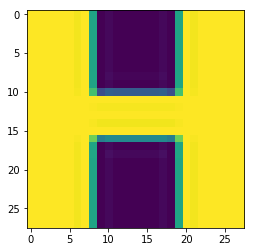

Corresponding label: H


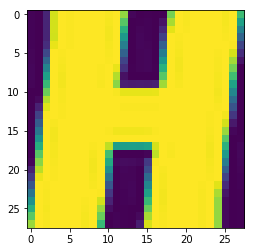

Corresponding label: H


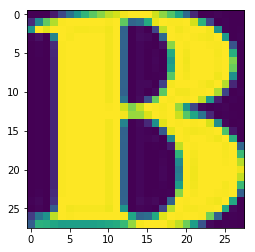

Corresponding label: B


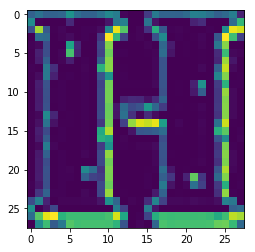

Corresponding label: H


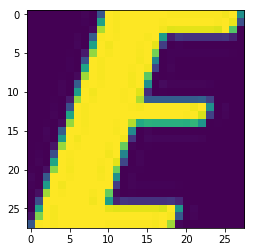

Corresponding label: E

Validation Set


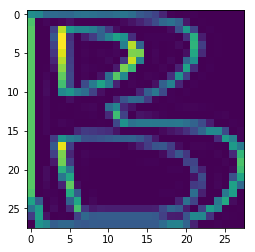

Corresponding label: B


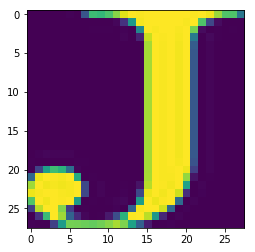

Corresponding label: J


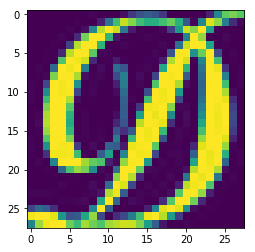

Corresponding label: D


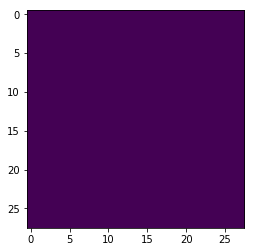

Corresponding label: I


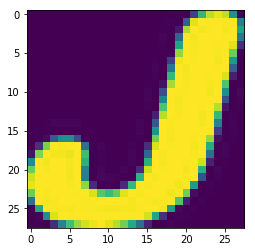

Corresponding label: J


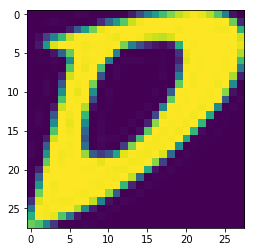

Corresponding label: D


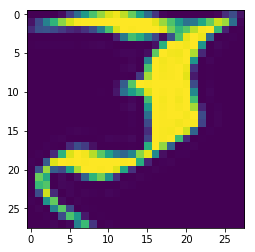

Corresponding label: J


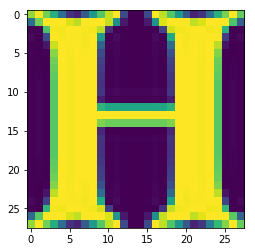

Corresponding label: H


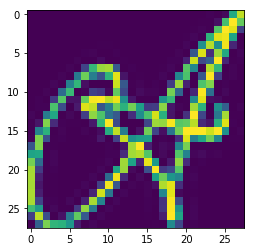

Corresponding label: A


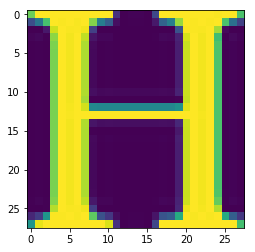

Corresponding label: H



In [47]:
# Problem 4
# To convince ourselves that the data is still fine after shuffling, we will run code similar to the display_sample_images()
# function used in Problem 2 to see if the images in the various datasets are still representative of their
# labels
def display_shuffled_sample(dataset, labels, num_to_display):
    label_vector = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    for i in range(0, num_to_display):
                        plt.imshow(dataset[i,:,:])
                        plt.show()
                        print('Corresponding label: ' + label_vector[labels[i]])
    print()

print('Training Set')
display_shuffled_sample(train_dataset, train_labels, 10)
print('Testing Set')
display_shuffled_sample(test_dataset, test_labels, 10)
print('Validation Set')
display_shuffled_sample(valid_dataset, valid_labels, 10)



In [48]:
# This code saves the above data so it can be loaded and reused later.
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [49]:
# This code prints the size of the above saved pickle
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [59]:
# Problem 5
# THIS IS AN UNOPTIMIZED SOLUTION, DO NOT RUN!
# The below code is a very naive implementation of overlap checking that is O(n^2). It essentially uses 
# a nested for loop to compare every value in 1 list to every value in the second list.
# An improved implementation is shown in the cell below
def count_overlap2(dataset_1, dataset_2):
    assert len(dataset_1.shape) == 3
    assert len(dataset_2.shape) == 3
    if(len(dataset_1) < len(dataset_2)):
        len_to_measure = len(dataset_1)
        other_len = len(dataset_2)
        primary_dataset = dataset_1
        secondary_dataset = dataset_2        
    else:
        len_to_measure = len(dataset_2)
        other_len = len(dataset_1)
        primary_dataset = dataset_2
        secondary_dataset = dataset_1
    num_overlap = 0
    for i in range(0, len_to_measure):
        for j in range(0, other_len):
            if(np.array_equal(primary_dataset[i,:,:], secondary_dataset[j,:,:])):
                num_overlap += 1
    return num_overlap

print('Overlap between training and validation: ' + str(count_overlap2(train_dataset, valid_dataset)))
print('Overlap between training and testing: ' + str(count_overlap2(train_dataset, test_dataset)))
print('Overlap between testing and validation: ' + str(count_overlap2(test_dataset, valid_dataset)))        

KeyboardInterrupt: 

In [63]:
# Problem 5
# This is the much optimized implementation of the overlap counter. Here, the first input dataset is 
# hashed to be the keys of a dictionary. Then, the function iterates through all values in the 
# second dataset and sees if each of these values is in the dictionary's keys. Since lookup of keys
# in a dictionary is a constant time operation, the complexity of this is now O(m+n) where m and n 
# are the lengths of each of the two datasets respectively
def count_overlap2_improved(dataset_1, dataset_2):
    dict1 = {}
    num_overlap = 0
    dataset_1.flags.writeable = False # This is black magic required for the ndarray to hash properly
    for key_index in range(0, len(dataset_1)):
        dict1[bytes(dataset_1[key_index,:,:].data)] = True # The value of 'True' is arbitrary
        # The use of the bytes() function above is simply to allow a numpy.ndarray to be hashed
    for search_index in range(0, len(dataset_2)):
        if(bytes(dataset_2[search_index,:,:].data) in dict1):
            num_overlap += 1    
    return num_overlap

print('Overlap between training and validation: ' + str(count_overlap2_improved(train_dataset, valid_dataset)))
print('Overlap between training and testing: ' + str(count_overlap2_improved(train_dataset, test_dataset)))
print('Overlap between testing and validation: ' + str(count_overlap2_improved(test_dataset, valid_dataset)))  

Overlap between training and validation: 1038
Overlap between training and testing: 1230
Overlap between testing and validation: 156


In [76]:
# Problem 6
# We will attempt to classify this data using the off-the-shelf Logistic Regression model implementation from
# sklearn

def train_log_and_compute_score(num_samples):
    # These options are specified so that the classifier 'converges' and also so that scikit learn doesn't 
    # complain
    logRegr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 1000)
    
    # Reshape the training set into a 2D array instead of 3D
    # We have to reshape into the form (n_samples, n_features)
    nsamples, nx, ny = train_dataset[0:num_samples,:,:].shape
    train_reshaped = train_dataset[0:num_samples,:,:].reshape((nsamples, nx * ny))
    
    # Reshape the testing set into a 2D array instead of 3D
    nsamples, nx, ny = test_dataset.shape
    test_reshaped = test_dataset.reshape((nsamples, nx * ny))
    
    logRegr.fit(train_reshaped, train_labels[0:num_samples])
    return logRegr.score(test_reshaped, test_labels)

print(train_log_and_compute_score(50))
print(train_log_and_compute_score(100))
print(train_log_and_compute_score(1000))
print(train_log_and_compute_score(5000))

0.5933
0.7176
0.8421
0.8458
